# Evaluate Model Predictions

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import tqdm
import os

Load model predictions

In [4]:
subset = "full"
kb="5"
species = "mouse_rat_human"
model = f"{subset}_{species}_{kb}kb"

# Load test metadata
data_dir = f"/home/elek/sds/sd17d003/Anamaria/splicevo/data/"
data_path = os.path.join(data_dir, f"splits_{subset}_{kb}kb", f"{species}", "test")

from splicevo.utils.data_utils import load_processed_data
test_seq, test_labels, test_alpha, test_beta, test_sse, test_species, condition_mask = load_processed_data(data_path)

meta_fn = os.path.join(data_path, "metadata.json")
with open(meta_fn, "r") as f:
    import json
    test_meta = json.load(f)

# Test windows metadata
meta_fn = os.path.join(data_path, "metadata.csv")
meta_df = pd.read_csv(meta_fn)

# Species
species_name_to_id = test_meta['species_mapping']
species_id_to_name = {v: k for k, v in species_name_to_id.items()}

# Load predictions
pred_dir = "/home/elek/sds/sd17d003/Anamaria/splicevo/predictions/transformer"
pred_path = os.path.join(pred_dir, model)

from splicevo.utils.data_utils import load_predictions
pred_labels, pred_probs, pred_sse, meta, true_labels, true_sse, condition_mask = load_predictions(pred_path)

# Load metadata
meta_fn = os.path.join(pred_path, "metadata.json")
with open(meta_fn, "r") as f:
    import json
    meta = json.load(f)

## Splice site classification

Inspect predictions vs true labels for the first few sequences.

In [5]:
# Splice sites in the first few test sequences
for i in range(4):
    print(f"\n(1) Donor splice sites in sequence {i}:")
    print(f"  actual       {np.where(true_labels[i] == 1)[0].tolist()}")
    print(f"  predicted    {np.where(pred_labels[i] == 1)[0].tolist()}")
    print(f"(2) Acceptor splice sites in sequence {i}:")
    print(f"  actual    {np.where(true_labels[i] == 2)[0].tolist()}")
    print(f"  predicted {np.where(pred_labels[i] == 2)[0].tolist()}")  


(1) Donor splice sites in sequence 0:
  actual       [0]
  predicted    [0, 103, 113, 122, 123, 124, 125, 138, 139, 146, 239, 325, 374, 449, 456, 558, 641, 800, 873, 962, 976, 978, 981, 1055, 1154, 1176, 1193, 1196, 1209, 1238, 1250, 1524, 1525, 1526, 1527, 1528, 1532, 1652, 1707, 1927, 2091, 2166, 2176, 2183, 2201, 2312, 2398, 2477, 2480, 2704, 2768, 2850, 2932, 3075, 3137, 3151, 3157, 3181, 3260, 3304, 3402, 3508, 3643, 3705, 3889, 4026, 4147, 4292, 4598, 4759, 4790, 4796, 4806, 4927]
(2) Acceptor splice sites in sequence 0:
  actual    []
  predicted [8, 62, 119, 120, 121, 141, 667, 980, 1054, 1143, 1192, 1237, 1263, 1293, 1577, 1882, 2048, 2261, 2271, 2344, 2457, 2580, 2849, 2922, 3093, 3096, 3100, 3127, 3249, 3332, 3434, 3521, 3540, 3764, 4226, 4291, 4499, 4740, 4743, 4760, 4774, 4859]

(1) Donor splice sites in sequence 1:
  actual       [4791]
  predicted    [93, 123, 157, 206, 262, 303, 346, 573, 644, 738, 849, 1018, 1165, 1198, 1207, 1212, 1244, 1261, 1263, 1272, 1275, 1277, 

For several sequences, check the predicted splice site probabilities against the true labels.


In [7]:
pred_labels, pred_probs, pred_sse, meta, true_labels, true_sse, condition_mask = load_predictions(pred_path)
for i, j in [(0, 0), (0, 103), (0, 113), (0, 122)]:
    print(f"Sequence {i}, position {j}:\n  true label: {true_labels[i,j]}\n  pred label: {pred_labels[i,j]}\n  porbs:{pred_probs[i,j,]}")

Sequence 0, position 0:
  true label: 1
  pred label: 1
  porbs:[2.1366249e-03 9.9694556e-01 9.1785262e-04]
Sequence 0, position 103:
  true label: 0
  pred label: 1
  porbs:[0.01664769 0.9816352  0.00171708]
Sequence 0, position 113:
  true label: 0
  pred label: 1
  porbs:[0.3699326  0.5773088  0.05275868]
Sequence 0, position 122:
  true label: 0
  pred label: 1
  porbs:[0.09107928 0.8309311  0.07798955]


For correctly and incorrectly predicted splice sites (1 and 2), plot the predicted probabilities distribution

In [31]:
correct_donor_probs = pred_probs[(true_labels == 1) & (pred_labels == 1), 1]
incorrect_donor_probs = pred_probs[(true_labels != 1) & (pred_labels == 1), 1]
correct_acceptor_probs = pred_probs[(true_labels == 2) & (pred_labels == 2), 2]
incorrect_acceptor_probs = pred_probs[(true_labels != 2) & (pred_labels == 2), 2]

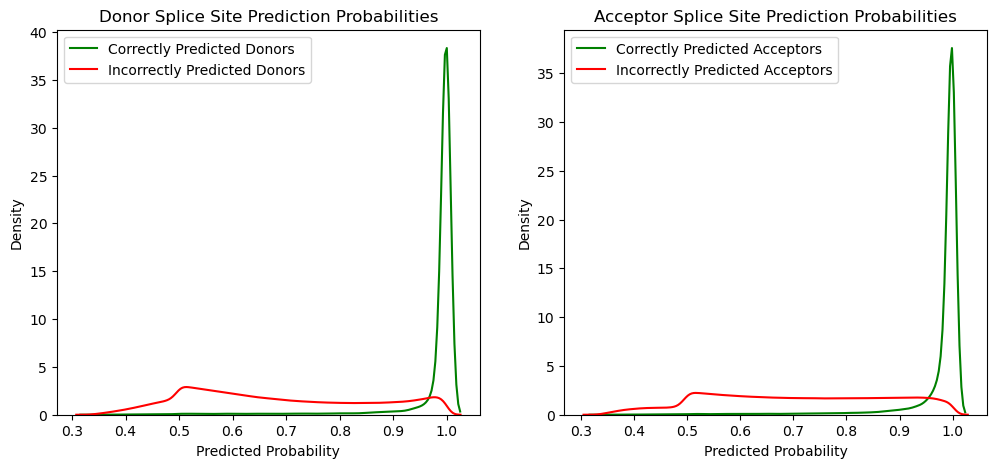

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.kdeplot(correct_donor_probs, label='Correctly Predicted Donors', color='g')
sns.kdeplot(incorrect_donor_probs, label='Incorrectly Predicted Donors', color='r')
plt.title('Donor Splice Site Prediction Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.subplot(1, 2, 2)
sns.kdeplot(correct_acceptor_probs, label='Correctly Predicted Acceptors', color='g')
sns.kdeplot(incorrect_acceptor_probs, label='Incorrectly Predicted Acceptors', color='r')
plt.title('Acceptor Splice Site Prediction Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.show()

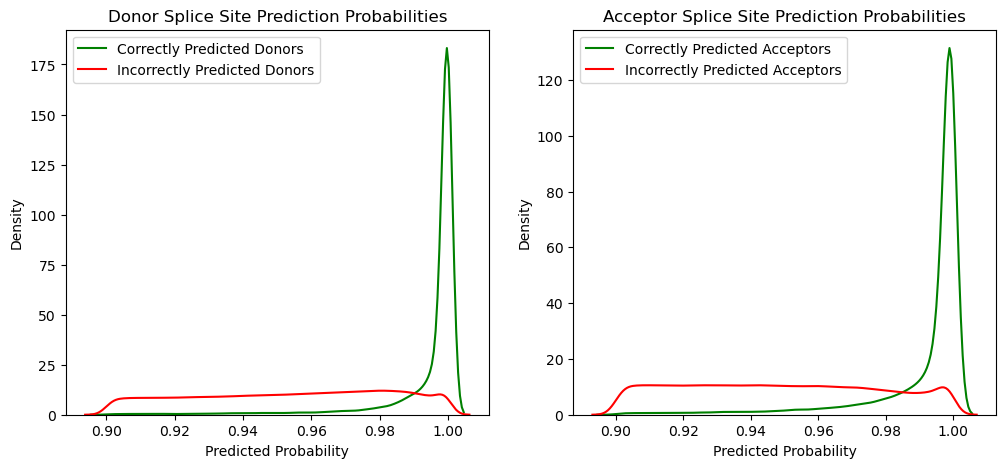

In [30]:
%matplotlib inline

# Modify predicted labels so that, among predicted positives, only those with prob > 0.9 are kept as positives
# otherwise change to negative (0)

high_confidence_mask = np.zeros_like(pred_labels, dtype=bool)
high_confidence_mask[(pred_labels == 1) & (pred_probs[:, :, 1] > 0.9)] = True
high_confidence_mask[(pred_labels == 2) & (pred_probs[:, :, 2] > 0.9)] = True
pred_labels_high_conf = np.where(high_confidence_mask, pred_labels, 0)

correct_donor_probs = pred_probs[(true_labels == 1) & (pred_labels_high_conf == 1), 1]
incorrect_donor_probs = pred_probs[(true_labels != 1) & (pred_labels_high_conf == 1), 1]
correct_acceptor_probs = pred_probs[(true_labels == 2) & (pred_labels_high_conf == 2), 2]
incorrect_acceptor_probs = pred_probs[(true_labels != 2) & (pred_labels_high_conf == 2), 2]

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.kdeplot(correct_donor_probs, label='Correctly Predicted Donors', color='g')
sns.kdeplot(incorrect_donor_probs, label='Incorrectly Predicted Donors', color='r')
plt.title('Donor Splice Site Prediction Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.subplot(1, 2, 2)
sns.kdeplot(correct_acceptor_probs, label='Correctly Predicted Acceptors', color='g')
sns.kdeplot(incorrect_acceptor_probs, label='Incorrectly Predicted Acceptors', color='r')
plt.title('Acceptor Splice Site Prediction Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.show()

Calculate PR-AUC, the area under the precision-recall curve.

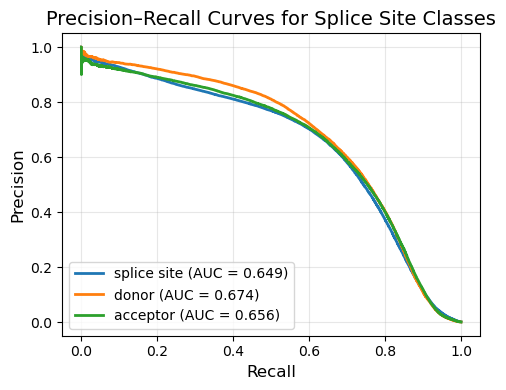

PR-AUC for splice site: 0.6488
PR-AUC for donor: 0.6743
PR-AUC for acceptor: 0.6556


In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

pr_auc_scores = {}
plt.figure(figsize=(5, 4))

class_labels = {0: 'splice site', 1: 'donor', 2: 'acceptor'}
class_colors = {0: 'tab:blue', 1: 'tab:orange', 2: 'tab:green'}

total_positions = true_labels.shape[0] * true_labels.shape[1]

for class_idx in range(3):
    color = class_colors[class_idx]
    label = class_labels[class_idx]
    if class_idx == 0:
        y_true = (true_labels != class_idx).astype(int).reshape(-1)
        y_scores = 1 - pred_probs[:, :, class_idx].reshape(-1)
        freq = np.sum(true_labels != class_idx) / total_positions
    else:
        y_true = (true_labels == class_idx).astype(int).reshape(-1)
        y_scores = pred_probs[:, :, class_idx].reshape(-1)
        freq = np.sum(true_labels == class_idx) / total_positions

    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    pr_auc_scores[class_idx] = pr_auc

    plt.plot(
        recall, precision,
        label=f"{label} (AUC = {pr_auc:.3f})",
        linewidth=2,
        color=color
    )
    #plt.hlines(
    #    y=freq, xmin=0, xmax=1,
    #    colors=color, linestyles='dashed',
    #    label=f'freq {label} ({freq:.3f})'
    #)

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision–Recall Curves for Splice Site Classes", fontsize=14)
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

for c, auc_score in pr_auc_scores.items():
    print(f"PR-AUC for {class_labels[c]}: {auc_score:.4f}")


### Threshold Optimization

Systematically evaluate different decision thresholds to find the optimal balance between precision and recall. This addresses the class imbalance problem by requiring higher confidence for positive predictions.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def evaluate_threshold(true_labels, pred_probs, threshold, class_idx):
    """
    Evaluate performance at a specific threshold for a given class.
    
    Args:
        true_labels: True labels array
        pred_probs: Predicted probabilities array
        threshold: Probability threshold for positive prediction
        class_idx: Class to evaluate (1=donor, 2=acceptor)
    """
    # Apply threshold to get predictions
    pred_labels_thresh = np.zeros_like(true_labels)
    if class_idx == 1:  # Donor
        pred_labels_thresh[pred_probs[:, :, 1] > threshold] = 1
    elif class_idx == 2:  # Acceptor
        pred_labels_thresh[pred_probs[:, :, 2] > threshold] = 2
    
    # Binarize for metrics
    y_true = (true_labels == class_idx).astype(int).flatten()
    y_pred = (pred_labels_thresh == class_idx).astype(int).flatten()
    
    # Calculate metrics
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Count predictions
    n_predicted_positive = np.sum(y_pred)
    n_true_positive = np.sum(y_true)
    n_correct = np.sum((y_pred == 1) & (y_true == 1))
    
    return {
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'n_predicted': n_predicted_positive,
        'n_true': n_true_positive,
        'n_correct': n_correct
    }

# Test range of thresholds
thresholds = np.arange(0.3, 1.0, 0.05)

# Evaluate donors (class 1)
donor_results = []
for thresh in thresholds:
    result = evaluate_threshold(true_labels, pred_probs, thresh, class_idx=1)
    donor_results.append(result)

# Evaluate acceptors (class 2)
acceptor_results = []
for thresh in thresholds:
    result = evaluate_threshold(true_labels, pred_probs, thresh, class_idx=2)
    acceptor_results.append(result)

donor_df = pd.DataFrame(donor_results)
acceptor_df = pd.DataFrame(acceptor_results)

print("Donor splice sites:")
print(donor_df.to_string(index=False))
print("\n\nAcceptor splice sites:")
print(acceptor_df.to_string(index=False))

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Donor plots
axes[0, 0].plot(donor_df['threshold'], donor_df['precision'], 'o-', label='Precision', color='#1f77b4', linewidth=2)
axes[0, 0].plot(donor_df['threshold'], donor_df['recall'], 's-', label='Recall', color='#ff7f0e', linewidth=2)
axes[0, 0].plot(donor_df['threshold'], donor_df['f1'], '^-', label='F1 Score', color='#2ca02c', linewidth=2)
axes[0, 0].axvline(x=1/3, color='gray', linestyle='--', alpha=0.5, label='Default (0.33)')
axes[0, 0].set_xlabel('Threshold', fontsize=12)
axes[0, 0].set_ylabel('Score', fontsize=12)
axes[0, 0].set_title('Donor Splice Sites: Performance vs Threshold', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_ylim(0, 1)

# Find optimal F1 threshold for donors
optimal_donor_idx = donor_df['f1'].idxmax()
optimal_donor_thresh = donor_df.loc[optimal_donor_idx, 'threshold']
axes[0, 0].axvline(x=optimal_donor_thresh, color='green', linestyle=':', linewidth=2, label=f'Optimal F1 ({optimal_donor_thresh:.2f})')

# Acceptor plots
axes[0, 1].plot(acceptor_df['threshold'], acceptor_df['precision'], 'o-', label='Precision', color='#1f77b4', linewidth=2)
axes[0, 1].plot(acceptor_df['threshold'], acceptor_df['recall'], 's-', label='Recall', color='#ff7f0e', linewidth=2)
axes[0, 1].plot(acceptor_df['threshold'], acceptor_df['f1'], '^-', label='F1 Score', color='#2ca02c', linewidth=2)
axes[0, 1].axvline(x=1/3, color='gray', linestyle='--', alpha=0.5, label='Default (0.33)')
axes[0, 1].set_xlabel('Threshold', fontsize=12)
axes[0, 1].set_ylabel('Score', fontsize=12)
axes[0, 1].set_title('Acceptor Splice Sites: Performance vs Threshold', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_ylim(0, 1)

# Find optimal F1 threshold for acceptors
optimal_acceptor_idx = acceptor_df['f1'].idxmax()
optimal_acceptor_thresh = acceptor_df.loc[optimal_acceptor_idx, 'threshold']
axes[0, 1].axvline(x=optimal_acceptor_thresh, color='green', linestyle=':', linewidth=2, label=f'Optimal F1 ({optimal_acceptor_thresh:.2f})')

# Precision-Recall curve for donors
axes[1, 0].plot(donor_df['recall'], donor_df['precision'], 'o-', linewidth=2, markersize=6, color='#d62728')
axes[1, 0].scatter(donor_df.loc[optimal_donor_idx, 'recall'], 
                   donor_df.loc[optimal_donor_idx, 'precision'], 
                   s=200, c='green', marker='*', zorder=10, 
                   label=f'Optimal (thresh={optimal_donor_thresh:.2f})')
axes[1, 0].set_xlabel('Recall', fontsize=12)
axes[1, 0].set_ylabel('Precision', fontsize=12)
axes[1, 0].set_title('Donor: Precision-Recall Tradeoff', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_xlim(0, 1)
axes[1, 0].set_ylim(0, 1)

# Precision-Recall curve for acceptors
axes[1, 1].plot(acceptor_df['recall'], acceptor_df['precision'], 'o-', linewidth=2, markersize=6, color='#d62728')
axes[1, 1].scatter(acceptor_df.loc[optimal_acceptor_idx, 'recall'], 
                   acceptor_df.loc[optimal_acceptor_idx, 'precision'], 
                   s=200, c='green', marker='*', zorder=10,
                   label=f'Optimal (thresh={optimal_acceptor_thresh:.2f})')
axes[1, 1].set_xlabel('Recall', fontsize=12)
axes[1, 1].set_ylabel('Precision', fontsize=12)
axes[1, 1].set_title('Acceptor: Precision-Recall Tradeoff', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)
axes[1, 1].set_xlim(0, 1)
axes[1, 1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"OPTIMAL THRESHOLDS (based on F1 score):")
print(f"{'='*60}")
print(f"Donor sites:    {optimal_donor_thresh:.3f}")
print(f"  Precision: {donor_df.loc[optimal_donor_idx, 'precision']:.4f}")
print(f"  Recall:    {donor_df.loc[optimal_donor_idx, 'recall']:.4f}")
print(f"  F1 Score:  {donor_df.loc[optimal_donor_idx, 'f1']:.4f}")
print(f"\nAcceptor sites: {optimal_acceptor_thresh:.3f}")
print(f"  Precision: {acceptor_df.loc[optimal_acceptor_idx, 'precision']:.4f}")
print(f"  Recall:    {acceptor_df.loc[optimal_acceptor_idx, 'recall']:.4f}")
print(f"  F1 Score:  {acceptor_df.loc[optimal_acceptor_idx, 'f1']:.4f}")
print(f"{'='*60}")

In [ ]:
# Visualize the impact of threshold adjustment on false positive distribution

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Donor sites
correct_donor_default = pred_probs[(true_labels == 1) & (pred_labels == 1), 1]
incorrect_donor_default = pred_probs[(true_labels != 1) & (pred_labels == 1), 1]
correct_donor_opt = pred_probs[(true_labels == 1) & (pred_labels_optimized == 1), 1]
incorrect_donor_opt = pred_probs[(true_labels != 1) & (pred_labels_optimized == 1), 1]

axes[0].hist([incorrect_donor_default, incorrect_donor_opt], 
             bins=30, alpha=0.6, label=['Default FP', 'Optimized FP'],
             color=['red', 'orange'])
axes[0].axvline(x=1/3, color='gray', linestyle='--', alpha=0.7, linewidth=2, label='Default threshold')
axes[0].axvline(x=optimal_donor_thresh, color='green', linestyle='--', alpha=0.7, linewidth=2, label='Optimized threshold')
axes[0].set_xlabel('Predicted Probability', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title(f'Donor False Positives Distribution\n(Reduced: {len(incorrect_donor_default)} → {len(incorrect_donor_opt)})', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Acceptor sites
correct_acceptor_default = pred_probs[(true_labels == 2) & (pred_labels == 2), 2]
incorrect_acceptor_default = pred_probs[(true_labels != 2) & (pred_labels == 2), 2]
correct_acceptor_opt = pred_probs[(true_labels == 2) & (pred_labels_optimized == 2), 2]
incorrect_acceptor_opt = pred_probs[(true_labels != 2) & (pred_labels_optimized == 2), 2]

axes[1].hist([incorrect_acceptor_default, incorrect_acceptor_opt], 
             bins=30, alpha=0.6, label=['Default FP', 'Optimized FP'],
             color=['red', 'orange'])
axes[1].axvline(x=1/3, color='gray', linestyle='--', alpha=0.7, linewidth=2, label='Default threshold')
axes[1].axvline(x=optimal_acceptor_thresh, color='green', linestyle='--', alpha=0.7, linewidth=2, label='Optimized threshold')
axes[1].set_xlabel('Predicted Probability', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title(f'Acceptor False Positives Distribution\n(Reduced: {len(incorrect_acceptor_default)} → {len(incorrect_acceptor_opt)})', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nFALSE POSITIVE REDUCTION:")
print("="*50)
print(f"Donor sites:    {len(incorrect_donor_default):,} → {len(incorrect_donor_opt):,} ({100*(1-len(incorrect_donor_opt)/len(incorrect_donor_default)):.1f}% reduction)")
print(f"Acceptor sites: {len(incorrect_acceptor_default):,} → {len(incorrect_acceptor_opt):,} ({100*(1-len(incorrect_acceptor_opt)/len(incorrect_acceptor_default)):.1f}% reduction)")

In [ ]:
# Apply optimized thresholds and compare with default
# Use the optimal thresholds found above

# Create predictions with optimal thresholds
pred_labels_optimized = np.zeros_like(true_labels)
pred_labels_optimized[pred_probs[:, :, 1] > optimal_donor_thresh] = 1
pred_labels_optimized[pred_probs[:, :, 2] > optimal_acceptor_thresh] = 2

# Compare default vs optimized predictions
print("COMPARISON: Default (argmax) vs Optimized Thresholds")
print("="*70)

class_names = {1: 'Donor', 2: 'Acceptor'}

for class_idx in [1, 2]:
    print(f"\n{class_names[class_idx]} Splice Sites:")
    print("-" * 70)
    
    y_true = (true_labels == class_idx).astype(int).flatten()
    y_pred_default = (pred_labels == class_idx).astype(int).flatten()
    y_pred_optimized = (pred_labels_optimized == class_idx).astype(int).flatten()
    
    # Default metrics
    prec_default = precision_score(y_true, y_pred_default, zero_division=0)
    rec_default = recall_score(y_true, y_pred_default, zero_division=0)
    f1_default = f1_score(y_true, y_pred_default, zero_division=0)
    
    # Optimized metrics
    prec_optimized = precision_score(y_true, y_pred_optimized, zero_division=0)
    rec_optimized = recall_score(y_true, y_pred_optimized, zero_division=0)
    f1_optimized = f1_score(y_true, y_pred_optimized, zero_division=0)
    
    # Display
    print(f"{'Metric':<15} {'Default':<12} {'Optimized':<12} {'Change':<12}")
    print(f"{'Precision':<15} {prec_default:<12.4f} {prec_optimized:<12.4f} {prec_optimized-prec_default:+.4f}")
    print(f"{'Recall':<15} {rec_default:<12.4f} {rec_optimized:<12.4f} {rec_optimized-rec_default:+.4f}")
    print(f"{'F1 Score':<15} {f1_default:<12.4f} {f1_optimized:<12.4f} {f1_optimized-f1_default:+.4f}")
    
    n_pred_default = np.sum(y_pred_default)
    n_pred_optimized = np.sum(y_pred_optimized)
    n_true = np.sum(y_true)
    
    print(f"\n{'Predictions':<15} {n_pred_default:<12} {n_pred_optimized:<12} {n_pred_optimized-n_pred_default:+}")
    print(f"{'True positives':<15} {n_true:<12} {n_true:<12}")
    print(f"{'False pos rate':<15} {(n_pred_default-n_true)/n_true:<12.2f} {(n_pred_optimized-n_true)/n_true:<12.2f}")

print("\n" + "="*70)

***

Calculate top-k accuracy by choosing a threshold to make predicted positive sites and actual positive sites have the same number, then computing the fraction of correctly predicted splice sites.

In [6]:
def top_k_accuracy(y_true, y_scores):
    # How many actual positive sites (k) are there?
    k = np.sum(y_true)
    # Select prediction value threshold at which there are k predicted positive sites
    threshold = np.sort(y_scores)[-k]
    # Predicted positive sites
    y_pred = (y_scores >= threshold).astype(int)
    # Calculate accuracy
    accuracy = np.sum((y_pred == 1) & (y_true == 1)) / k
    return accuracy

top_k_acc = {}
for class_idx in range(3):
    if class_idx == 0:
        y_true = (true_labels != class_idx).astype(int)
        y_scores = 1 - pred_probs[:, :, class_idx].reshape(-1)
    else:
        y_true = (true_labels == class_idx).astype(int)
        y_scores = pred_probs[:,:,class_idx]
    y_true = y_true.reshape(-1)
    y_scores = y_scores.reshape(-1)
    acc = top_k_accuracy(y_true, y_scores)
    top_k_acc[class_idx] = acc
    print(f"Top-k accuracy for class {class_idx}: {acc:.4f}")

Top-k accuracy for class 0: 0.7892
Top-k accuracy for class 1: 0.7898
Top-k accuracy for class 2: 0.7872


### Performance correlation with intron / transcript length

Given that this model is trained on short sequence context, I expect it will perform better for short transcripts. Check if this is the case by calculating performance metrics for transcripts of different lengths.  

For this, I first need information about the transcrips associated to each sequence in the test set.

In [ ]:
import pandas as pd

# Load metadata.csv from test set directory
meta_fn = os.path.join(data_path, "metadata.csv")
meta_df = pd.read_csv(meta_fn)

# Check species in test data
species_idx = meta_df['species_id'].values.tolist()
species_id_to_name = {v: k for k, v in test_species.items()}
species_names = [species_id_to_name[idx] for idx in species_idx]
for sp in set(species_names):
    print(f"{species_names.count(sp)} {sp}")

In [ ]:
# Load gtf files
from splicevo.io.gene_annotation import GTFProcessor
gtf_fns = {
    "human": "/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz",
    "mouse": "/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Mus_musculus.gtf.gz",
    "rat": "/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Rattus_norvegicus.gtf.gz"
}
if "human" in species_names:
    chromosomes=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', 'X', 'Y', 'MT']
    gtf_human = GTFProcessor(gtf_fns["human"]).load_gtf(chromosomes=chromosomes)
if "mouse" in species_names:
    chromosomes=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', 'X', 'Y', 'MT']
    gtf_mouse = GTFProcessor(gtf_fns["mouse"]).load_gtf(chromosomes=chromosomes)
if "rat" in species_names:
    chromosomes=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', 'X', 'MT']
    gtf_rat = GTFProcessor(gtf_fns["rat"]).load_gtf(chromosomes=chromosomes)

In [ ]:
# Get positions of splice sites from true_labels (sequence idx and offset in the sequence) into a dataframe
splice_sites = []
for seq_idx in range(true_labels.shape[0]):
    seq_meta = meta_df.iloc[seq_idx]
    chrom = seq_meta['chromosome']
    start_pos = seq_meta['window_start']
    species = species_id_to_name[seq_meta['species_id']]
    for pos in range(true_labels.shape[1]):
        label = true_labels[seq_idx, pos]
        if label == 1 or label == 2:
            genomic_pos = start_pos + pos
            splice_sites.append({
                'sequence_index': seq_idx,
                'sequence_offset': pos,
                'species': species,
                'chromosome': chrom,
                'genomic_position': genomic_pos,
                'label': label,
                'predicted_label': pred_labels[seq_idx, pos]
            })
splice_sites_df = pd.DataFrame(splice_sites)
splice_sites_df.head()

In [ ]:
# Get overlap with exons from GTFs
def get_transcript_info_optimized(row, gtf_dicts):
    species = str(row['species'])
    chrom = str(row['chromosome'])
    pos = int(row['genomic_position'])
    
    if species not in gtf_dicts or gtf_dicts[species] is None:
        return pd.Series({
            'transcript_ids': [],
            'gene_ids': [],
            'transcript_lengths': [],
            'num_transcripts': 0,
            'num_genes': 0
        })
    
    gtf_idx = gtf_dicts[species]
    
    if chrom not in gtf_idx['chrom'].values:
        return pd.Series({
            'transcript_ids': [],
            'gene_ids': [],
            'transcript_lengths': [],
            'num_transcripts': 0,
            'num_genes': 0
        })
    
    # Fast lookup: pre-filtered by chromosome
    chrom_data = gtf_idx[gtf_idx['chrom'] == chrom]
    overlapping = chrom_data[(chrom_data['start'] <= pos) & (pos <= chrom_data['end'])]
    
    if len(overlapping) > 0:
        transcript_ids = overlapping['transcript_id'].tolist()
        gene_ids = overlapping['gene_id'].tolist()
        transcript_lengths = (overlapping['end'] - overlapping['start'] + 1).tolist()
        
        return pd.Series({
            'transcript_ids': transcript_ids,
            'gene_ids': gene_ids,
            'transcript_lengths': transcript_lengths,
            'num_transcripts': len(overlapping),
            'num_genes': len(set(gene_ids))
        })
    else:
        return pd.Series({
            'transcript_ids': [],
            'gene_ids': [],
            'transcript_lengths': [],
            'num_transcripts': 0,
            'num_genes': 0
        })

# Build GTF indexes once
gtf_dicts = {}
if 'gtf_human' in locals():
    gtf_dicts['human'] = gtf_human[gtf_human['feature'] == 'transcript'].copy()
if 'gtf_mouse' in locals():
    gtf_dicts['mouse'] = gtf_mouse[gtf_mouse['feature'] == 'transcript'].copy()
if 'gtf_rat' in locals():
    gtf_dicts['rat'] = gtf_rat[gtf_rat['feature'] == 'transcript'].copy()

splice_sites_df_head = splice_sites_df.head(1000)

# Use lambda to pass gtf_dicts to apply
splice_site_transcript_info = splice_sites_df_head.apply(
    lambda row: get_transcript_info_optimized(row, gtf_dicts), 
    axis=1
)
splice_sites_df_head = pd.concat([splice_sites_df_head, splice_site_transcript_info], axis=1)
splice_sites_df_head.head()

In [ ]:
# Split each row into multiple rows if there are multiple transcripts
splice_sites_expanded = splice_sites_df_head.explode(['transcript_ids', 'gene_ids', 'transcript_lengths'])
splice_sites_expanded.head()

In [ ]:
# Select the shortest transcript for each genomic position
splice_sites_expanded['transcript_lengths'] = splice_sites_expanded['transcript_lengths'].astype(int)
shortest_transcripts = splice_sites_expanded.loc[
    splice_sites_expanded.groupby(
        ['sequence_index', 'sequence_offset', 'species', 'chromosome', 'genomic_position', 'label', 'predicted_label']
    )['transcript_lengths'].idxmin()
]
#splice_sites_expanded = shortest_transcripts.reset_index(drop=True)

In [ ]:
# Build exon index for fast lookup by transcript_id
def build_exon_index(gtf):
    """Pre-index GTF exons by (species, transcript_id) for O(1) lookup"""
    exons = gtf[gtf['feature'] == 'exon'].copy()
    exons = exons.sort_values(['transcript_id', 'start'])
    # Group by transcript_id and store as dict for fast access
    exon_index = {}
    for transcript_id, group in exons.groupby('transcript_id'):
        exon_index[transcript_id] = group.sort_values('start').reset_index(drop=True)
    return exon_index

# Build exon indexes once
exon_indexes = {}
if 'gtf_human' in locals():
    exon_indexes['human'] = build_exon_index(gtf_human)
if 'gtf_mouse' in locals():
    exon_indexes['mouse'] = build_exon_index(gtf_mouse)
if 'gtf_rat' in locals():
    exon_indexes['rat'] = build_exon_index(gtf_rat)

def get_intron_length_fast(row, exon_indexes):
    """Fast intron length lookup using pre-indexed exons"""
    species = str(row['species'])
    pos = int(row['genomic_position'])
    label = int(row['label'])
    transcript_id = str(row['transcript_ids'])
    
    if species not in exon_indexes:
        return np.nan
    
    if transcript_id not in exon_indexes[species]:
        return np.nan
    
    exons = exon_indexes[species][transcript_id]
    
    if label == 1:  # donor site
        following_exons = exons[exons['start'] >= pos]
        if not following_exons.empty:
            return following_exons.iloc[0]['start'] - pos
    elif label == 2:  # acceptor site
        preceding_exons = exons[exons['end'] <= pos]
        if not preceding_exons.empty:
            return pos - preceding_exons.iloc[-1]['end']
    
    return np.nan

splice_sites_expanded['intron_length'] = splice_sites_expanded.apply(
    lambda row: get_intron_length_fast(row, exon_indexes), 
    axis=1
)
splice_sites_expanded

In [ ]:
# Group by transcript length bins
length_bins = [0, 500, 1000, 2000, 5000, 10000, 50000, 100000, 500000, 1000000]
splice_sites_expanded['length_bin'] = pd.cut(splice_sites_expanded['transcript_lengths'], bins=length_bins)
splice_sites_expanded.head()

# Group by intron length bins
intron_length_bins = [0, 100, 200, 500, 1000, 5000, 10000, 50000]
splice_sites_expanded['length_bin'] = pd.cut(splice_sites_expanded['intron_length'], bins=intron_length_bins)
splice_sites_expanded.head()

# Select unique genomic positions and intron lengths pairs 
splice_sites_expanded = splice_sites_expanded.drop_duplicates(
    subset=['species', 'chromosome' ,'genomic_position', 'intron_length']
)

# Remove rows with NaN intron lengths
splice_sites_expanded = splice_sites_expanded.dropna(subset=['intron_length'])

# Remove introns shorter than 3 nt
splice_sites_expanded = splice_sites_expanded[splice_sites_expanded['intron_length'] >= 3]

splice_sites_expanded

In [ ]:
# Group by bin and count correct predictions
grouped = splice_sites_expanded.groupby('length_bin').apply(
    lambda df: pd.Series({
        'total_sites': len(df),
        'correct_predictions': np.sum(df['label'] == df['predicted_label'])
    })
)
grouped['accuracy'] = grouped['correct_predictions'] / grouped['total_sites']
grouped.reset_index(inplace=True)
grouped.head()

# Plot accuracy vs transcript length bins as lineplot, and number of sites as barplot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(
    grouped['length_bin'].astype(str),
    grouped['accuracy'],
    marker='o',
    color='tab:blue',
    label='Accuracy'
)
ax2.bar(
    grouped['length_bin'].astype(str),
    grouped['total_sites'],
    alpha=0.3,
    color='tab:orange',
    label='Number of Sites'
)
ax1.set_xlabel('Length Bins (bp)', fontsize=12)
ax1.set_ylabel('Accuracy', color='tab:blue', fontsize=12)
ax2.set_ylabel('Number of Splice Sites', color='tab:orange', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax1.set_ylim(0, 1)
#ax2.set_yscale('log')
plt.title('Model Accuracy vs Intron Length', fontsize=14)
fig = plt.gcf()
fig.tight_layout()
plt.show()


## Splice usage regression

Splice usage prediction performance on the test data.

In [9]:
# Calculate the mean squared error for each species, tissue and timepoint
from sklearn.metrics import mean_squared_error
mse_dict = {}
conds = meta['conditions']
species = meta_df['species_id']
for sp in set(species):
    sp_indices = [i for i, s in enumerate(species) if s == sp]
    sp_n = species_id_to_name[sp]
    for i, _ in enumerate(conds):
        id = f"{sp_n}_{conds[i]}"
        true_sse_ = true_sse[sp_indices, :, i]
        pred_sse_ = pred_sse[sp_indices, :, i]
        # Replace NaN values in true_sse_ with 0
        true_sse_ = np.nan_to_num(true_sse_)
        # Select non-NaN values
        mask = ~np.isnan(true_sse_)
        true_sse_vals = true_sse_[mask]
        pred_sse_vals = pred_sse_[mask]
        mse = mean_squared_error(true_sse_vals, pred_sse_vals)
        mse_dict[id] = mse

# Make a dataframe: species, tissue, timepoint, mse
mse_df = pd.DataFrame(list(mse_dict.items()), columns=['Sample', 'MSE'])
mse_df[['Species', 'Tissue', 'Timepoint']] = mse_df['Sample'].str.split('_', expand=True)
mse_df['Timepoint'] = mse_df['Timepoint'].astype(int)
mse_df.sort_values(['Species', 'Tissue', "Timepoint"], ascending=True, inplace=True)
mse_df

,Sample,MSE,Species,Tissue,Timepoint
0,human_Brain_1,0.003513,human,Brain,1
6,human_Brain_2,0.000428,human,Brain,2
7,human_Brain_3,0.000189,human,Brain,3
8,human_Brain_4,0.001232,human,Brain,4
9,human_Brain_5,0.002900,human,Brain,5
...,...,...,...,...,...
284,rat_Testis_11,0.003356,rat,Testis,11
285,rat_Testis_12,0.003014,rat,Testis,12
286,rat_Testis_13,0.001224,rat,Testis,13
287,rat_Testis_14,0.001221,rat,Testis,14


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 3))
species_list = mse_df['Species'].unique()
for i, species in enumerate(species_list):
    plt.subplot(1, len(species_list), i + 1)
    for tissue in mse_df[mse_df['Species'] == species]['Tissue'].unique():
        tissue_data = mse_df[(mse_df['Species'] == species) & (mse_df['Tissue'] == tissue)]
        plt.plot(
            tissue_data['Timepoint'].astype(int),
            np.sqrt(tissue_data['MSE']),
            marker='o',
            label=tissue
        )
    plt.title(f'SEE prediction: {species}', fontsize=12)
    plt.xlabel('Timepoint', fontsize=10)
    plt.ylabel('RMSE', fontsize=10)
    plt.ylim(0, np.sqrt(mse_df['MSE']).max() * 1.1)
    plt.grid()
plt.tight_layout()
plt.legend(title='Tissue', fontsize=8, bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.show()


Density plot of predicted vs true splice usage (SSE) values.

In [10]:
# For every sequence, identify positions that are not NaN in all tissues, then compare values
num_sequences = true_sse.shape[0]
num_positions = true_sse.shape[1]
num_tissues = true_sse.shape[2]
print(f"Number of sequences: {num_sequences}; tissues: {num_tissues}")

matched_positions = {}

for seq_idx in range(num_sequences):
    print(f"Processing sequence {seq_idx + 1}/{num_sequences}", end='\r')
    # Find positions where all tissues are not NaN for this sequence
    valid_positions = np.where(np.all(~np.isnan(true_sse[seq_idx, :, :]), axis=1))[0]
    # Find positions where at least one tissue is not NaN for this sequence
    # valid_positions = np.where(np.any(~np.isnan(true_sse[seq_idx, :, :]), axis=1))[0]
    if len(valid_positions) == 0:
        continue
    for pos in valid_positions:
        true_vals = true_sse[seq_idx, pos, :]
        pred_vals = pred_sse[seq_idx, pos, :]
        true_vals = np.nan_to_num(true_vals)
        matched_positions[(seq_idx, pos)] = { "true": true_vals, "pred": pred_vals }

print(f"Number of matched positions: {len(matched_positions)}")


Number of sequences: 58823; tissues: 99
Number of matched positions: 50408


In [ ]:
# Combine all matched positions into a single dataframe for plotting
import pandas as pd
conds = meta['conditions']
all_data = []
for (seq_idx, pos), vals in matched_positions.items():
    for tissue_idx in range(num_tissues):
        all_data.append({
            'sequence': seq_idx,
            'position': pos,
            'group': conds[tissue_idx],
            'true_SSE': vals['true'][tissue_idx],
            'pred_SSE': vals['pred'][tissue_idx]
        })  

all_data_df = pd.DataFrame(all_data)
all_data_df['Tissue'] = all_data_df['group'].apply(lambda x: x.split('_')[0])
all_data_df['Timepoint'] = all_data_df['group'].apply(lambda x: int(x.split('_')[1]))
all_data_df

In [ ]:
all_data_df.to_csv(os.path.join(pred_path, "evaluation", "matched_sse_positions.csv"), index=False)

In [13]:
all_data_df=pd.read_csv(os.path.join(pred_path, "evaluation", "matched_sse_positions.csv"))

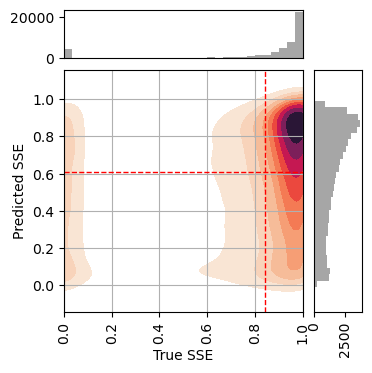

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

samples = all_data_df['group'].unique()[0:1] # Only one timepoint
axes = {}
num_tissues = len(samples)
num_cols = 1
num_rows = (num_tissues + num_cols - 1) // num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4), squeeze=False)

for i, tissue in enumerate(samples):
    tissue_data = all_data_df[all_data_df['group'] == tissue]

    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]

    # Scatter plot
    #ax.scatter(
    #    tissue_data['true_SSE'],
    #    tissue_data['pred_SSE'],
    #    alpha=0.2,
    #    s=4
    #)

    # 2d density plot
    sns.kdeplot(
        x=tissue_data['true_SSE'],
        y=tissue_data['pred_SSE'],
        levels=10,
        fill = True,
        cmap="rocket_r",
        ax=ax
    )

    # Top histogram (True SSE)
    ax_histx = ax.inset_axes([0, 1.05, 1, 0.2], sharex=ax)
    ax_histx.hist(
        tissue_data['true_SSE'],
        bins=30,
        color='gray',
        alpha=0.7
    )
    ax_histx.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)

    # Right histogram (Pred SSE)
    ax_histy = ax.inset_axes([1.05, 0, 0.2, 1], sharey=ax)
    ax_histy.hist(
        tissue_data['pred_SSE'],
        bins=30,
        orientation='horizontal',
        color='gray',
        alpha=0.7
    )
    ax_histy.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)

    plt.setp(ax_histy.get_xticklabels(), rotation=90, ha='center')
    plt.setp(ax.get_xticklabels(), rotation=90, ha='center')

    ax_histy.set_xlabel('')
    ax_histx.set_xlabel('')
    ax_histy.set_ylabel('')

    # Add mean lines
    mean_true = tissue_data['true_SSE'].mean()
    mean_pred = tissue_data['pred_SSE'].mean()
    ax.axvline(mean_true, color='red', linestyle='--', linewidth=1, label='Mean True')
    ax.axhline(mean_pred, color='red', linestyle='--', linewidth=1, label='Mean Pred')

    #ax.set_title(f'{tissue}', fontsize=10)
    ax.set_xlabel('True SSE', fontsize=10)
    ax.set_ylabel('Predicted SSE', fontsize=10)
    ax.set_xlim(0, 1)
    #ax.set_ylim(0, 1)
    ax.grid()

plt.tight_layout()


Calculate correlation between predicted and true splice usage values across timepoints and tissues.

In [15]:
# Group by sequence and position, and calculate correlation between true and predicted SSE values
correlation_results = []
for (seq_idx, pos, tissue), group in all_data_df.groupby(['sequence', 'position', 'Tissue']):
    true_vals = group['true_SSE'].values
    pred_vals = group['pred_SSE'].values
    if len(true_vals) < 2:
        continue
    correlation = np.corrcoef(true_vals, pred_vals)[0, 1]
    correlation_results.append({
        'sequence': seq_idx,
        'position': pos,
        'tissue': tissue,
        'correlation': correlation
    })

correlation_df = pd.DataFrame(correlation_results)
correlation_df.sort_values(by='correlation', ascending=False)

/home/elek/miniforge3/envs/splicevo/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/elek/miniforge3/envs/splicevo/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,sequence,position,tissue,correlation
10706,2231,610,Kidney,0.998485
9338,1919,649,Brain,0.998480
26015,5529,836,Kidney,0.998204
27419,5877,152,Brain,0.998185
20314,4374,927,Brain,0.998139
...,...,...,...,...
352097,58766,982,Liver,NaN
352104,58767,749,Liver,NaN
352111,58767,854,Liver,NaN
352118,58767,969,Liver,NaN


In [ ]:
correlation_df.to_csv(os.path.join(pred_path, "evaluation", "sse_correlation_per_position.csv"), index=False)

In [ ]:
correlation_df = pd.read_csv(os.path.join(pred_path, "evaluation", "sse_correlation_per_position.csv"))

In [16]:
# How many are NaN?
nas = correlation_df['correlation'].isna()
print(
    f"{nas.sum()} ({nas.mean() * 100:.2f}%) of the correlation values are NaN."
)

1691 (0.48%) of the correlation values are NaN.


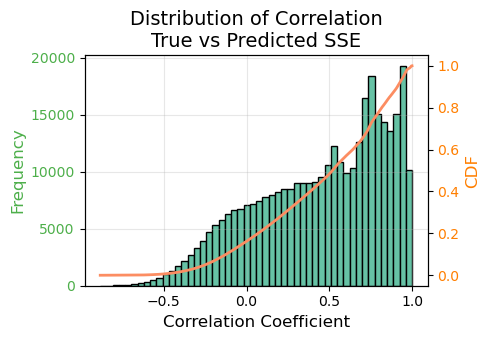

In [17]:
# Cumulative distribution
sorted_corr = np.sort(correlation_df['correlation'].dropna())
cdf = np.arange(1, len(sorted_corr) + 1) / len(sorted_corr)

# Plot distribution of correlations
fig, ax1 = plt.subplots(figsize=(5, 3.5))
ax1.hist(correlation_df['correlation'].dropna(), bins=50, color='#66c2a5', edgecolor='black')
ax1.set_xlabel('Correlation Coefficient', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12, color='#4daf4a')
ax1.tick_params(axis='y', labelcolor='#4daf4a')

ax2 = ax1.twinx()
ax2.plot(sorted_corr, cdf, color='#fc8d62', linewidth=2, label='CDF')
ax2.set_ylabel('CDF', fontsize=12, color='#ff7f00')
ax2.tick_params(axis='y', labelcolor='#ff7f00')

plt.title('Distribution of Correlation\nTrue vs Predicted SSE', fontsize=14)
ax1.grid(alpha=0.3)
fig.tight_layout()
plt.show()

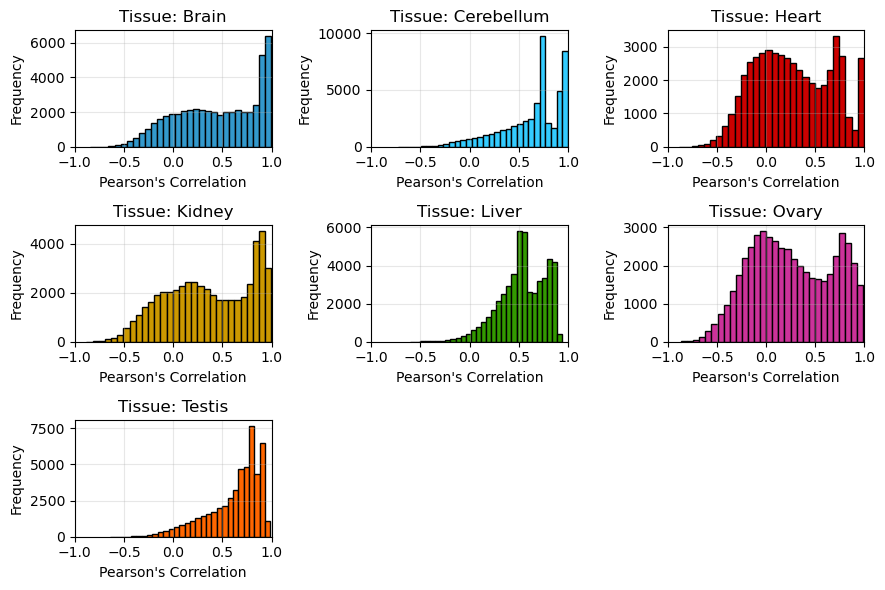

In [18]:
# Define tissue colors
tissue_colors = {
    'Brain': '#3399cc',
    'Cerebellum': '#34ccff',
    'Heart': '#cc0100',
    'Kidney': '#cc9900',
    'Liver': '#339900',
    'Ovary': '#cc329a',
    'Testis': '#ff6600'
}

unique_tissues = all_data_df['Tissue'].unique()
num_tissues = len(unique_tissues)
num_cols = 3
num_rows = (num_tissues + num_cols - 1) // num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 2), squeeze=False)
for i, tissue in enumerate(unique_tissues):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    tissue_corrs = correlation_df[correlation_df['tissue'] == tissue]['correlation'].dropna()
    tissue_color = tissue_colors.get(tissue, '#000000')
    ax.hist(tissue_corrs, bins=30, color=tissue_color, edgecolor='black')
    ax.set_title(f'Tissue: {tissue}', fontsize=12)
    ax.set_xlabel("Pearson's Correlation", fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_xlim(-1, 1)
    ax.grid(alpha=0.3)
plt.tight_layout()
for j in range(i + 1, num_rows * num_cols):
    row = j // num_cols
    col = j % num_cols
    fig.delaxes(axs[row][col])
plt.show()

Select interesting example to show

In [19]:
top_examples = correlation_df.sort_values(by='correlation', ascending=False)[1:8]
top_examples

,sequence,position,tissue,correlation
9338,1919,649,Brain,0.998480
26015,5529,836,Kidney,0.998204
27419,5877,152,Brain,0.998185
20314,4374,927,Brain,0.998139
16257,3473,35,Kidney,0.998092
21553,4564,510,Brain,0.998088
10643,2224,610,Kidney,0.998073


In [20]:
plot_df = all_data_df[(all_data_df['sequence'].isin(top_examples['sequence'])) & (all_data_df['position'].isin(top_examples['position']))]
plot_df['site'] = plot_df['sequence'].astype(str) + '_' + plot_df['position'].astype(str)
plot_df['tissue'] = plot_df['group'].apply(lambda x: x.split('_')[0])
plot_df['timepoint'] = plot_df['group'].apply(lambda x: x.split('_')[1])
plot_df

/tmp/ipykernel_1887958/3557751785.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['site'] = plot_df['sequence'].astype(str) + '_' + plot_df['position'].astype(str)
/tmp/ipykernel_1887958/3557751785.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['tissue'] = plot_df['group'].apply(lambda x: x.split('_')[0])
/tmp/ipykernel_1887958/3557751785.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

,sequence,position,group,true_SSE,pred_SSE,Tissue,Timepoint,site,tissue,timepoint
132066,1919,649,Brain_1,0.983,0.863098,Brain,1,1919_649,Brain,1
132067,1919,649,Brain_10,0.800,0.671315,Brain,10,1919_649,Brain,10
132068,1919,649,Brain_11,0.000,-0.007419,Brain,11,1919_649,Brain,11
132069,1919,649,Brain_12,0.000,0.011667,Brain,12,1919_649,Brain,12
132070,1919,649,Brain_13,0.000,0.009871,Brain,13,1919_649,Brain,13
...,...,...,...,...,...,...,...,...,...,...
387877,5877,152,Testis_5,0.000,0.450575,Testis,5,5877_152,Testis,5
387878,5877,152,Testis_6,0.000,0.269643,Testis,6,5877_152,Testis,6
387879,5877,152,Testis_7,1.000,0.693922,Testis,7,5877_152,Testis,7
387880,5877,152,Testis_8,0.932,0.773764,Testis,8,5877_152,Testis,8


/tmp/ipykernel_1887958/6538556.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['timepoint'] = pd.Categorical(plot_df['timepoint'], categories=timepoint_order, ordered=True)


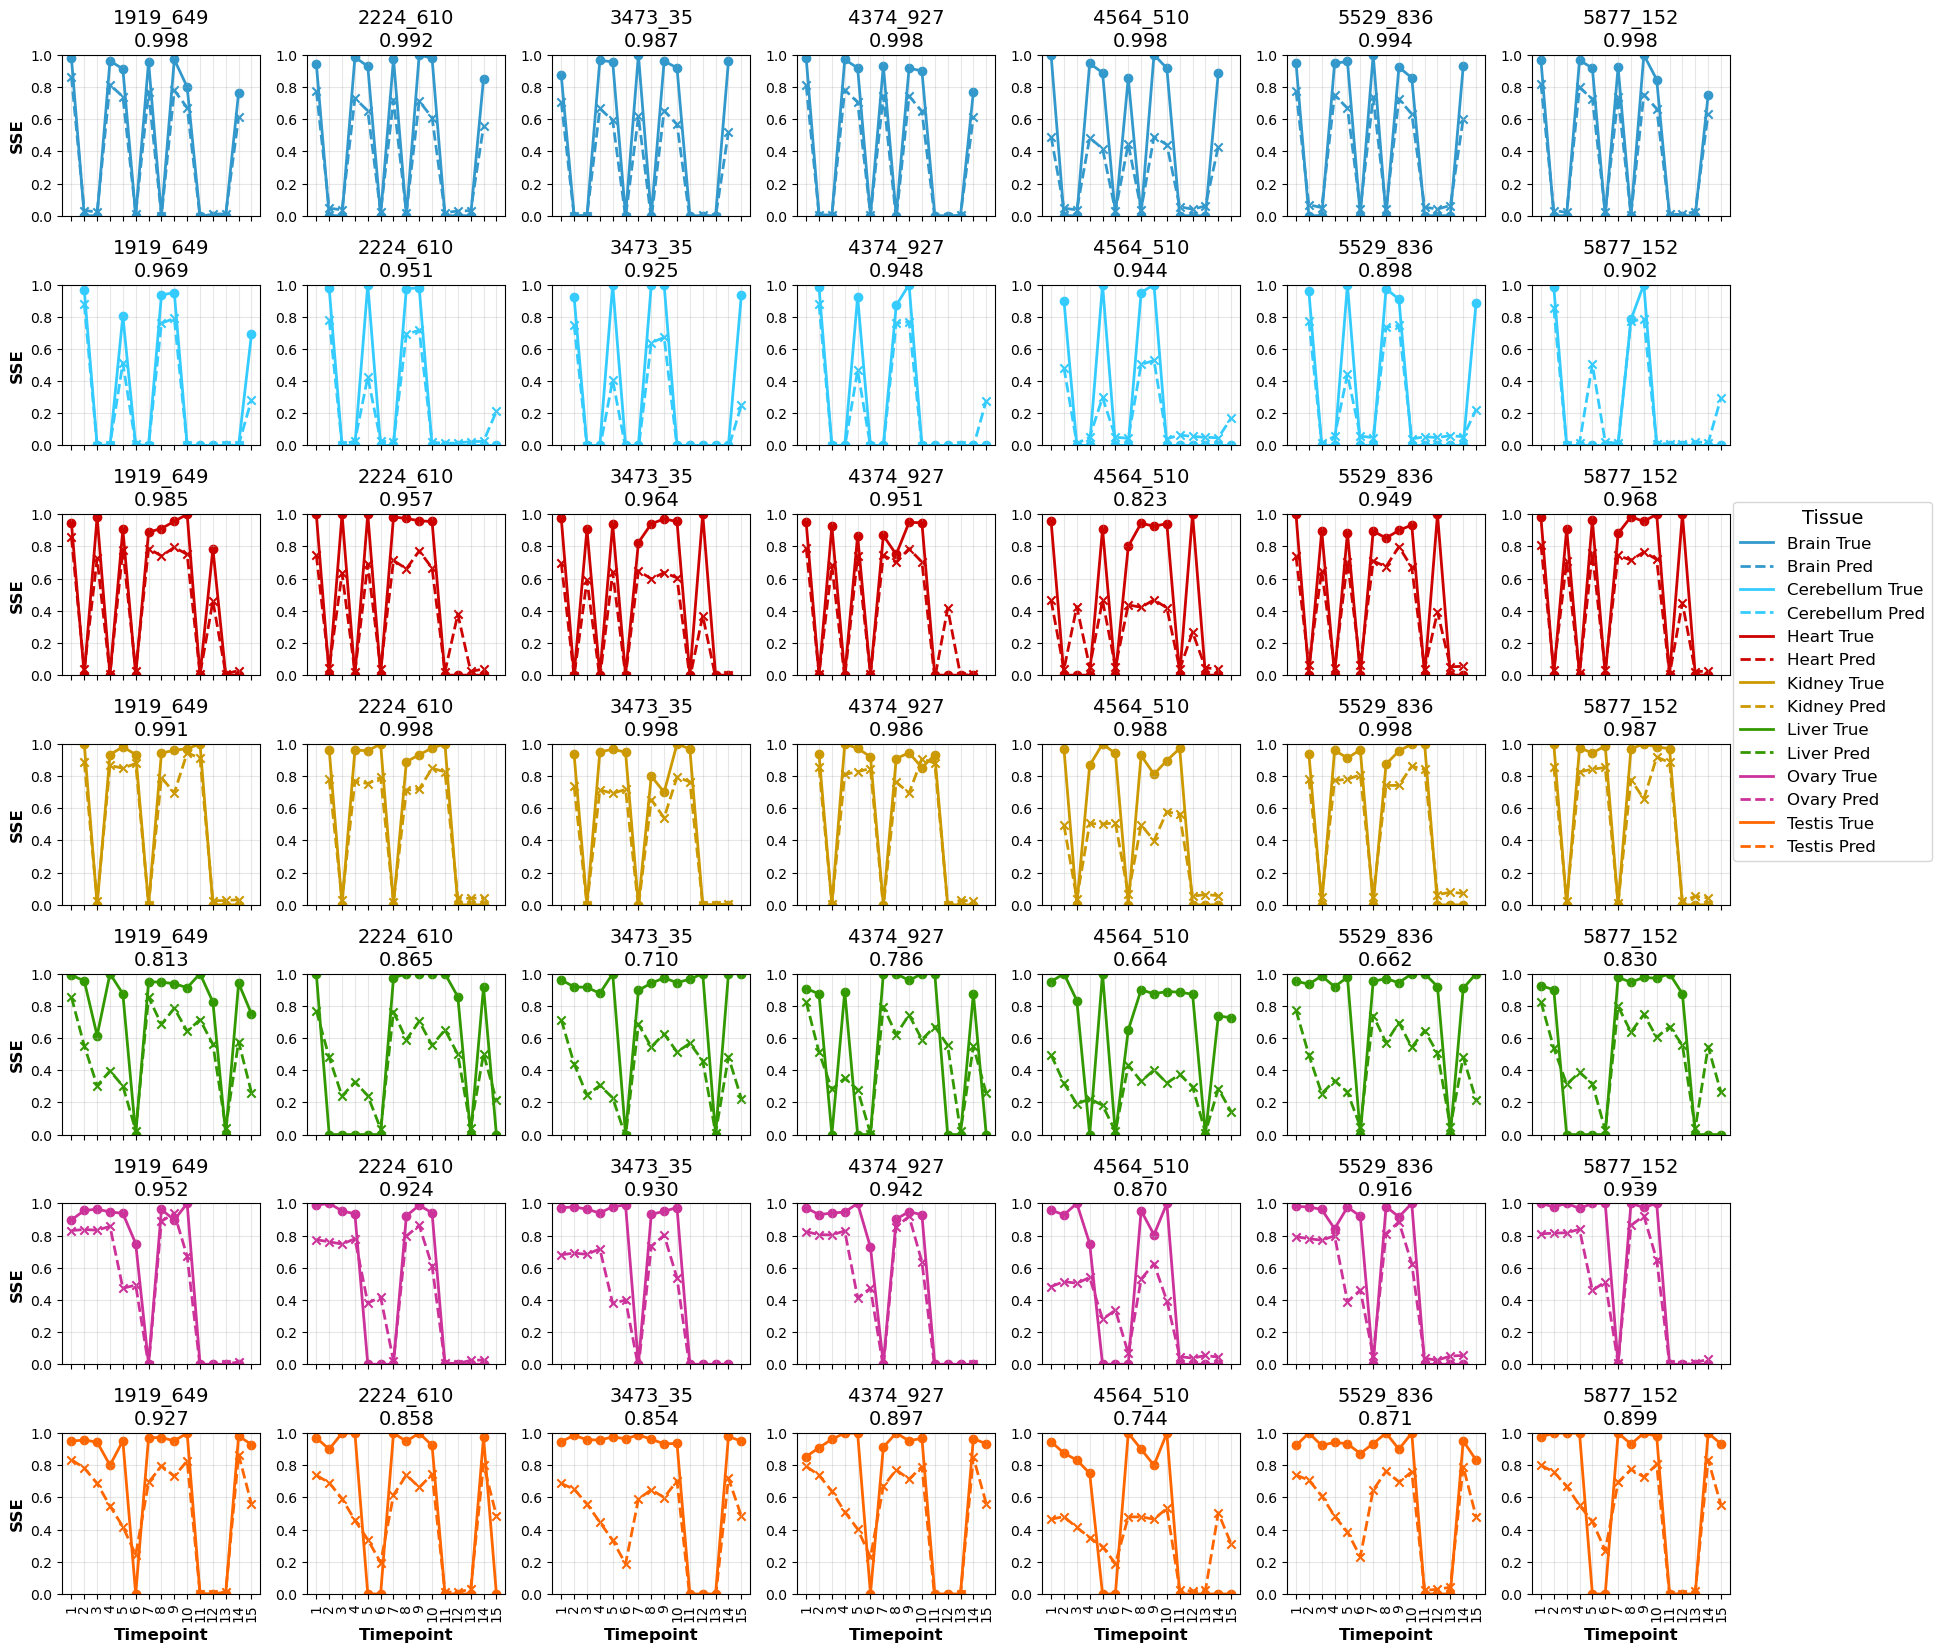

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import make_interp_spline

# Define tissue colors
tissue_colors = {
    'Brain': '#3399cc',
    'Cerebellum': '#34ccff',
    'Heart': '#cc0100',
    'Kidney': '#cc9900',
    'Liver': '#339900',
    'Ovary': '#cc329a',
    'Testis': '#ff6600'
}

unique_sites = plot_df['site'].unique()
smooth = False

timepoint_order = sorted(plot_df['timepoint'].unique(), key=lambda x: int(''.join(filter(str.isdigit, x))))
plot_df['timepoint'] = pd.Categorical(plot_df['timepoint'], categories=timepoint_order, ordered=True)

n_sites = len(unique_sites)
n_tissues = len(plot_df['tissue'].unique())
fig, axes = plt.subplots(n_tissues, n_sites, figsize=(2.5 * n_sites, 2.5 * n_tissues), sharex='col')

if n_sites == 1 and n_tissues == 1:
    axes = axes.reshape(1, 1)
elif n_sites == 1:
    axes = axes.reshape(n_tissues, 1)
elif n_tissues == 1:
    axes = axes.reshape(1, n_sites)

legend_handles, legend_labels = [], []

for col_idx, site in enumerate(unique_sites):
    site_data = plot_df[plot_df['site'] == site]
    for tissue in site_data['tissue'].unique():
        row_idx = list(plot_df['tissue'].unique()).index(tissue)
        tissue_data = site_data[site_data['tissue'] == tissue].sort_values('timepoint')
        color = tissue_colors.get(tissue, '#000000')
        x_values = tissue_data['timepoint'].cat.codes
        y_sse_true = tissue_data['true_SSE'].values
        y_sse_pred = tissue_data['pred_SSE'].values
        correlation = np.corrcoef(y_sse_true, y_sse_pred)[0, 1]

        def smooth_spline(x, y):
            if smooth and len(x) > 3:
                x_dense = np.linspace(x.min(), x.max(), 100)
                if len(np.unique(x)) < 4:
                    return x, y
                spline = make_interp_spline(x, y, k=2)
                y_smooth = spline(x_dense)
                return x_dense, y_smooth
            else:
                return x, y

        # True SSE: solid line
        x_sse, y_sse_true_smooth = smooth_spline(x_values, y_sse_true)
        line_true, = axes[row_idx, col_idx].plot(x_sse, y_sse_true_smooth, label=f'{tissue} True', color=color, linewidth=2, linestyle='-')
        axes[row_idx, col_idx].scatter(x_values, y_sse_true, color=color, marker='o', s=36)

        # Predicted SSE: dashed line
        x_sse, y_sse_pred_smooth = smooth_spline(x_values, y_sse_pred)
        line_pred, = axes[row_idx, col_idx].plot(x_sse, y_sse_pred_smooth, label=f'{tissue} Pred', color=color, linewidth=2, linestyle='--')
        axes[row_idx, col_idx].scatter(x_values, y_sse_pred, color=color, marker='x', s=36)

        if col_idx == 0:
            legend_handles.extend([line_true, line_pred])
            legend_labels.extend([f'{tissue} True', f'{tissue} Pred'])

        axes[row_idx, col_idx].set_ylim(0, 1)
        axes[row_idx, col_idx].set_title(f'{site}\n{correlation:.3f}', fontsize=14)
        axes[row_idx, col_idx].set_xticks(range(len(timepoint_order)))
        axes[row_idx, col_idx].set_xticklabels(timepoint_order, rotation=90)
        axes[row_idx, col_idx].grid(True, alpha=0.3)

# Set y labels for first column
for row_idx in range(n_tissues):
    axes[row_idx, 0].set_ylabel('SSE', fontsize=12, fontweight='bold')

# Set x labels for last row
for col_idx in range(n_sites):
    axes[-1, col_idx].set_xlabel('Timepoint', fontsize=12, fontweight='bold')

fig.legend(legend_handles, legend_labels, loc='lower center', bbox_to_anchor=(1.05, 0.5),
           title='Tissue', title_fontsize=14, fontsize=12, ncol=1)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()
